/home/aziza/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


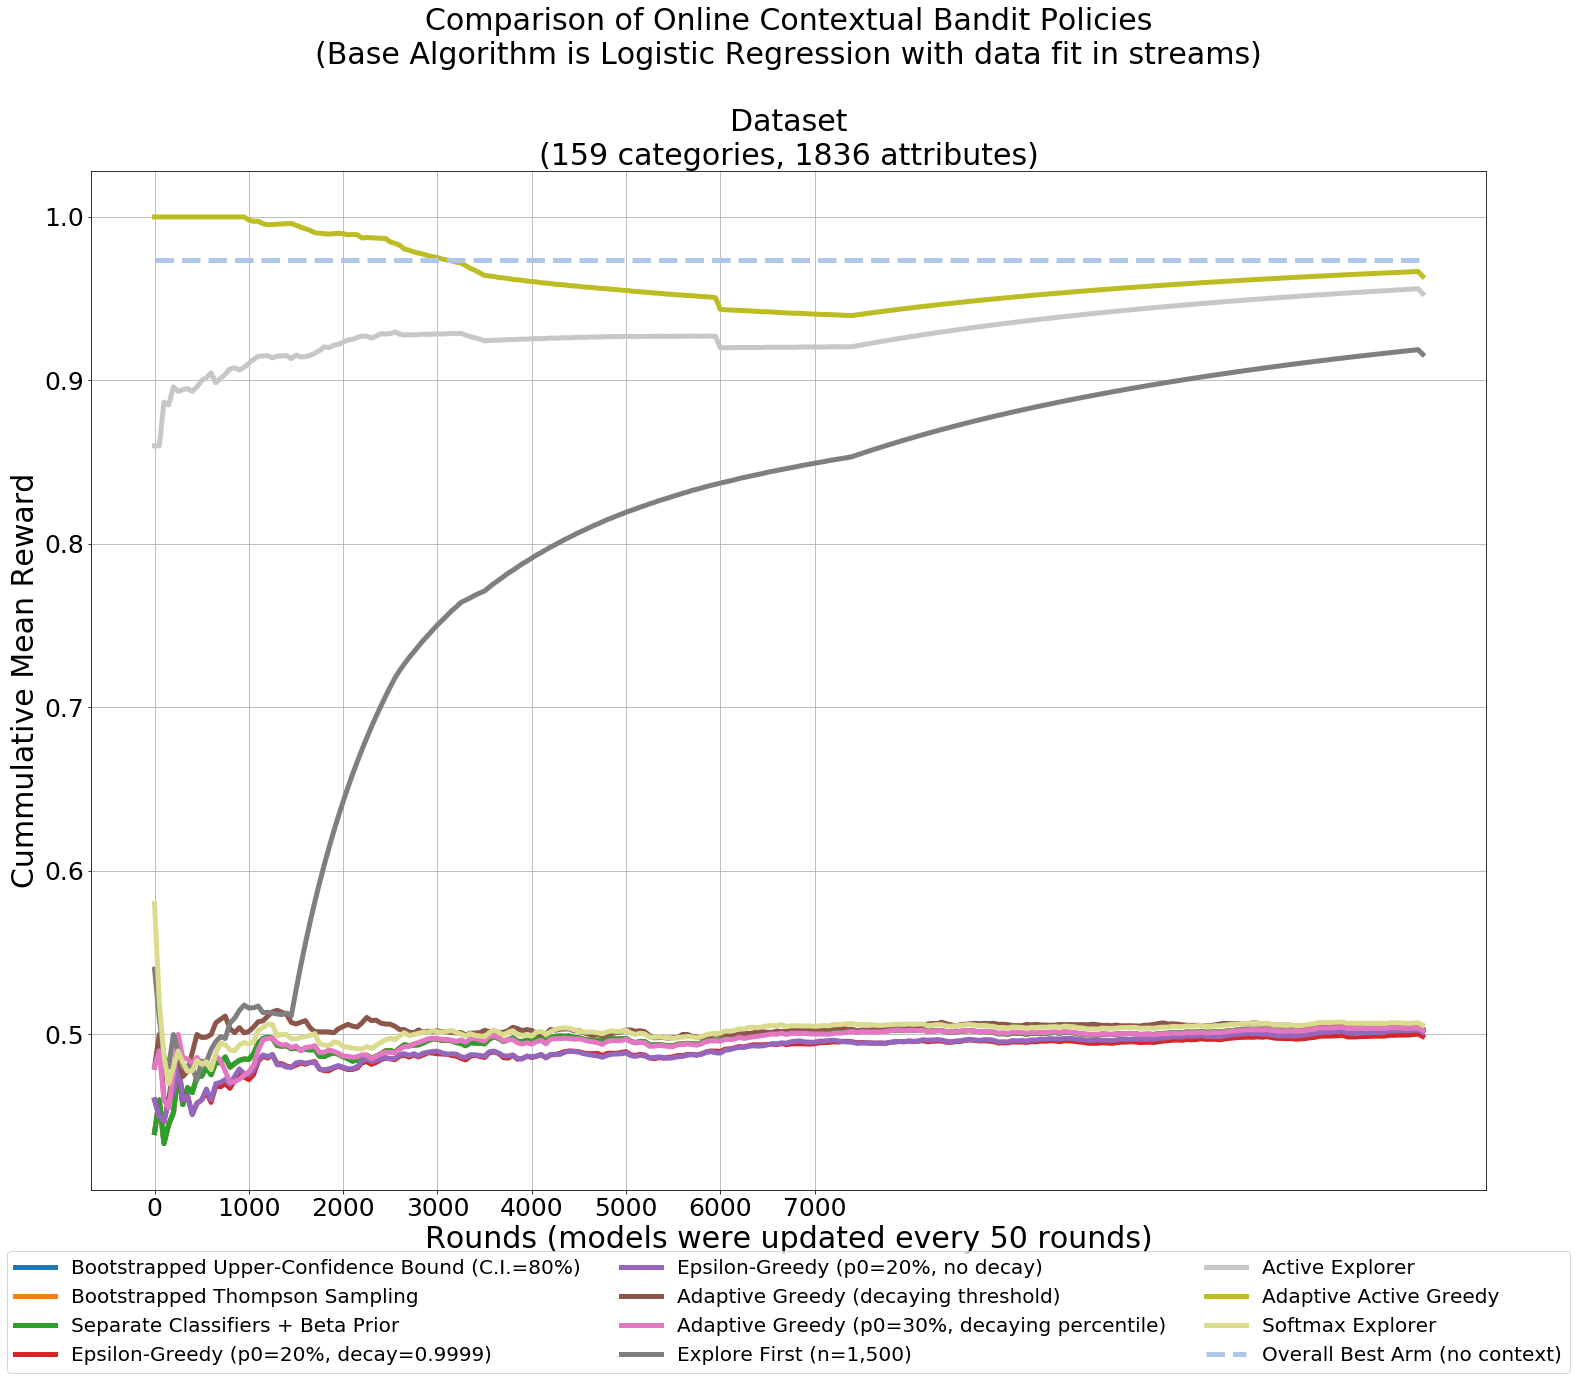

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_1.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

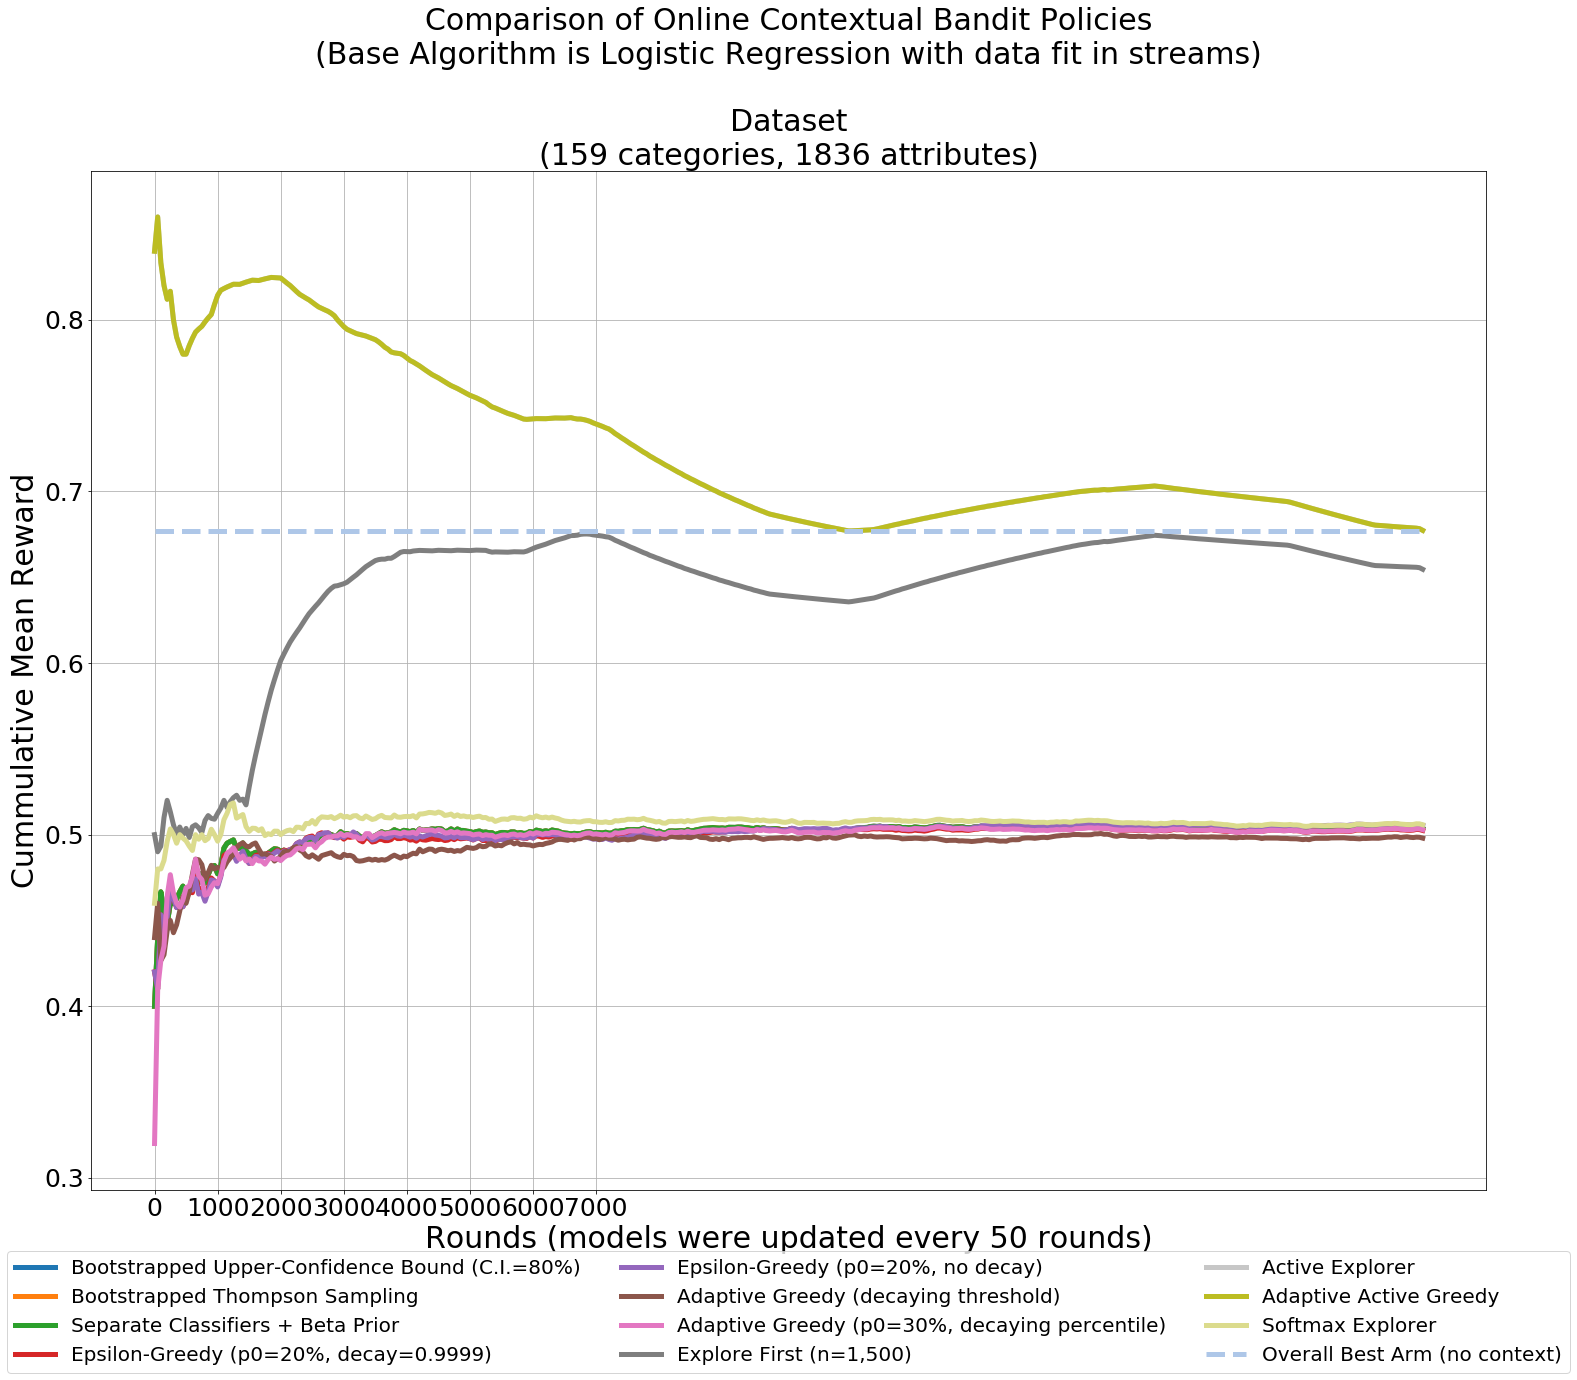

In [2]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_2.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

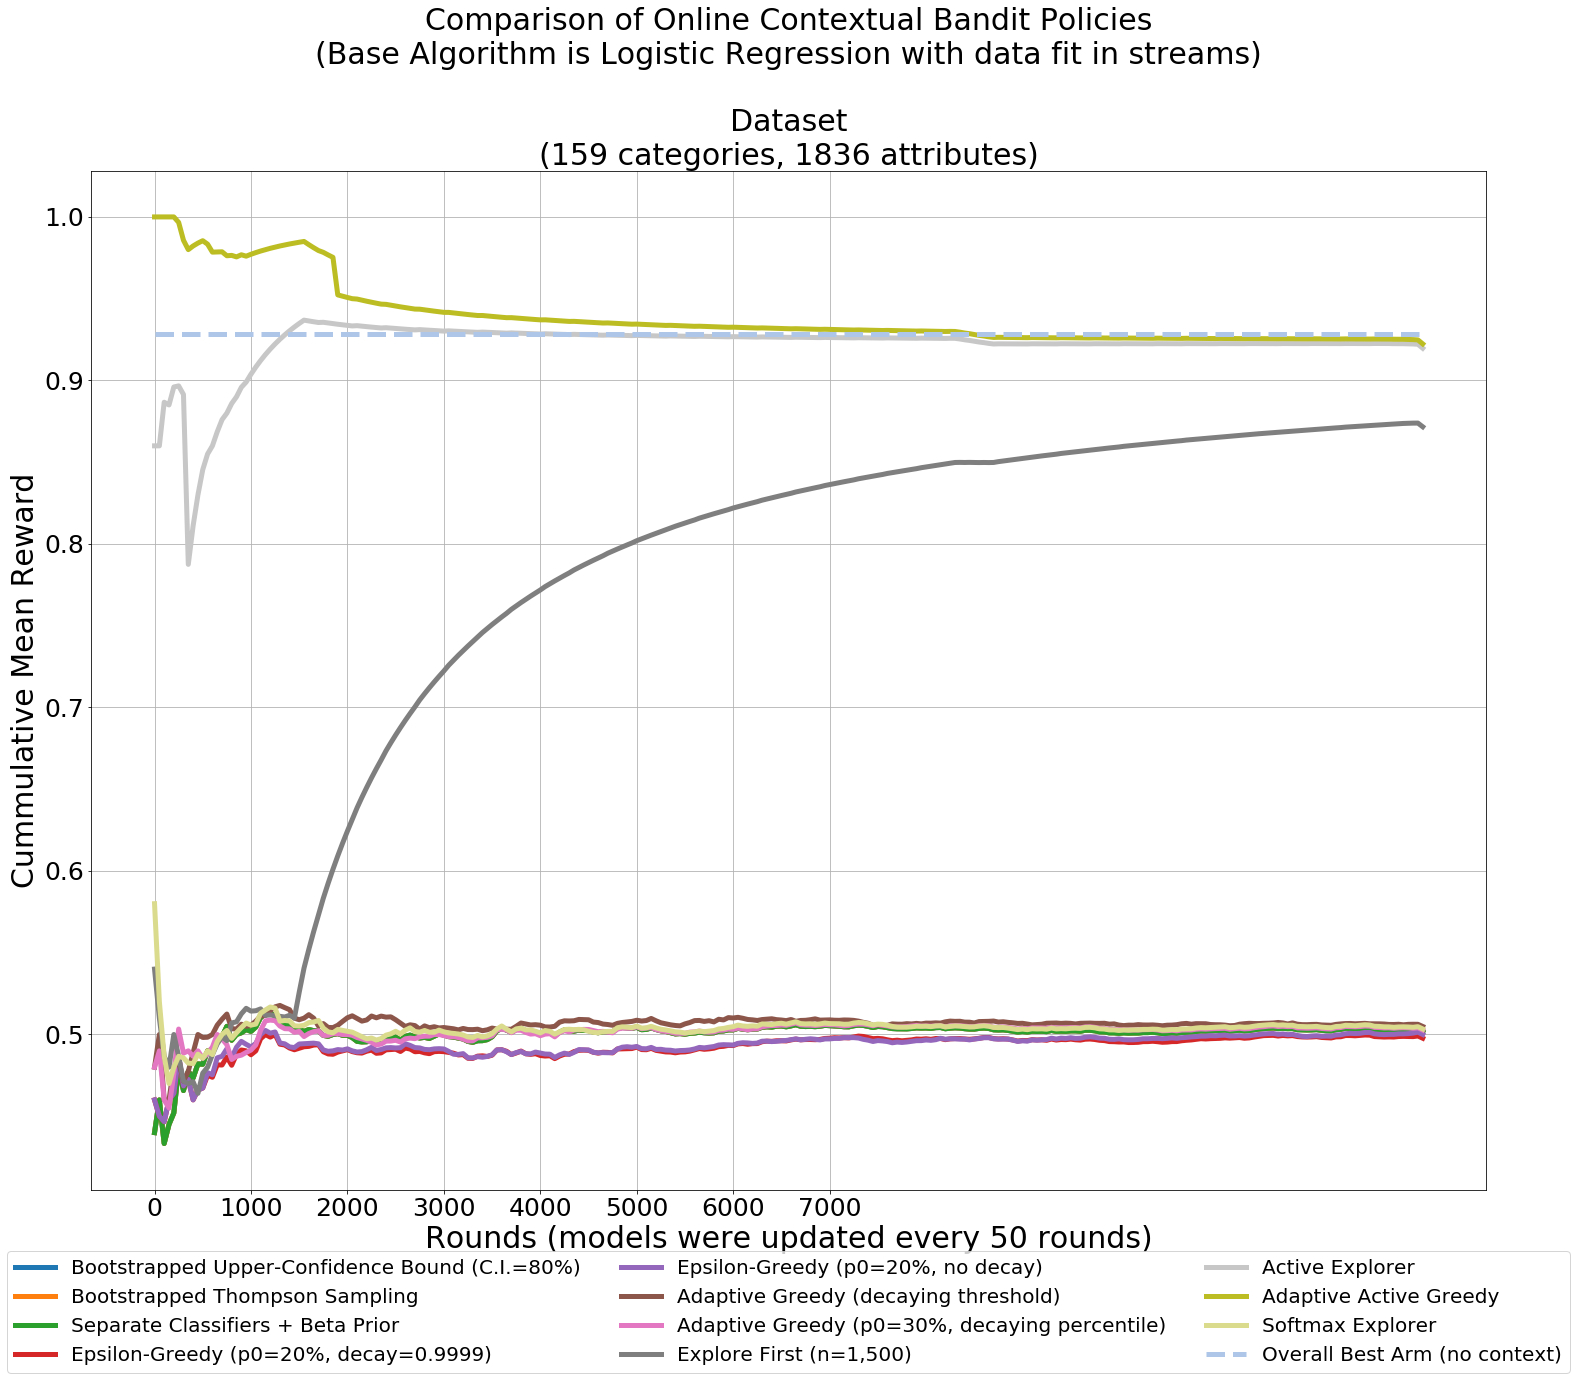

In [4]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_3.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

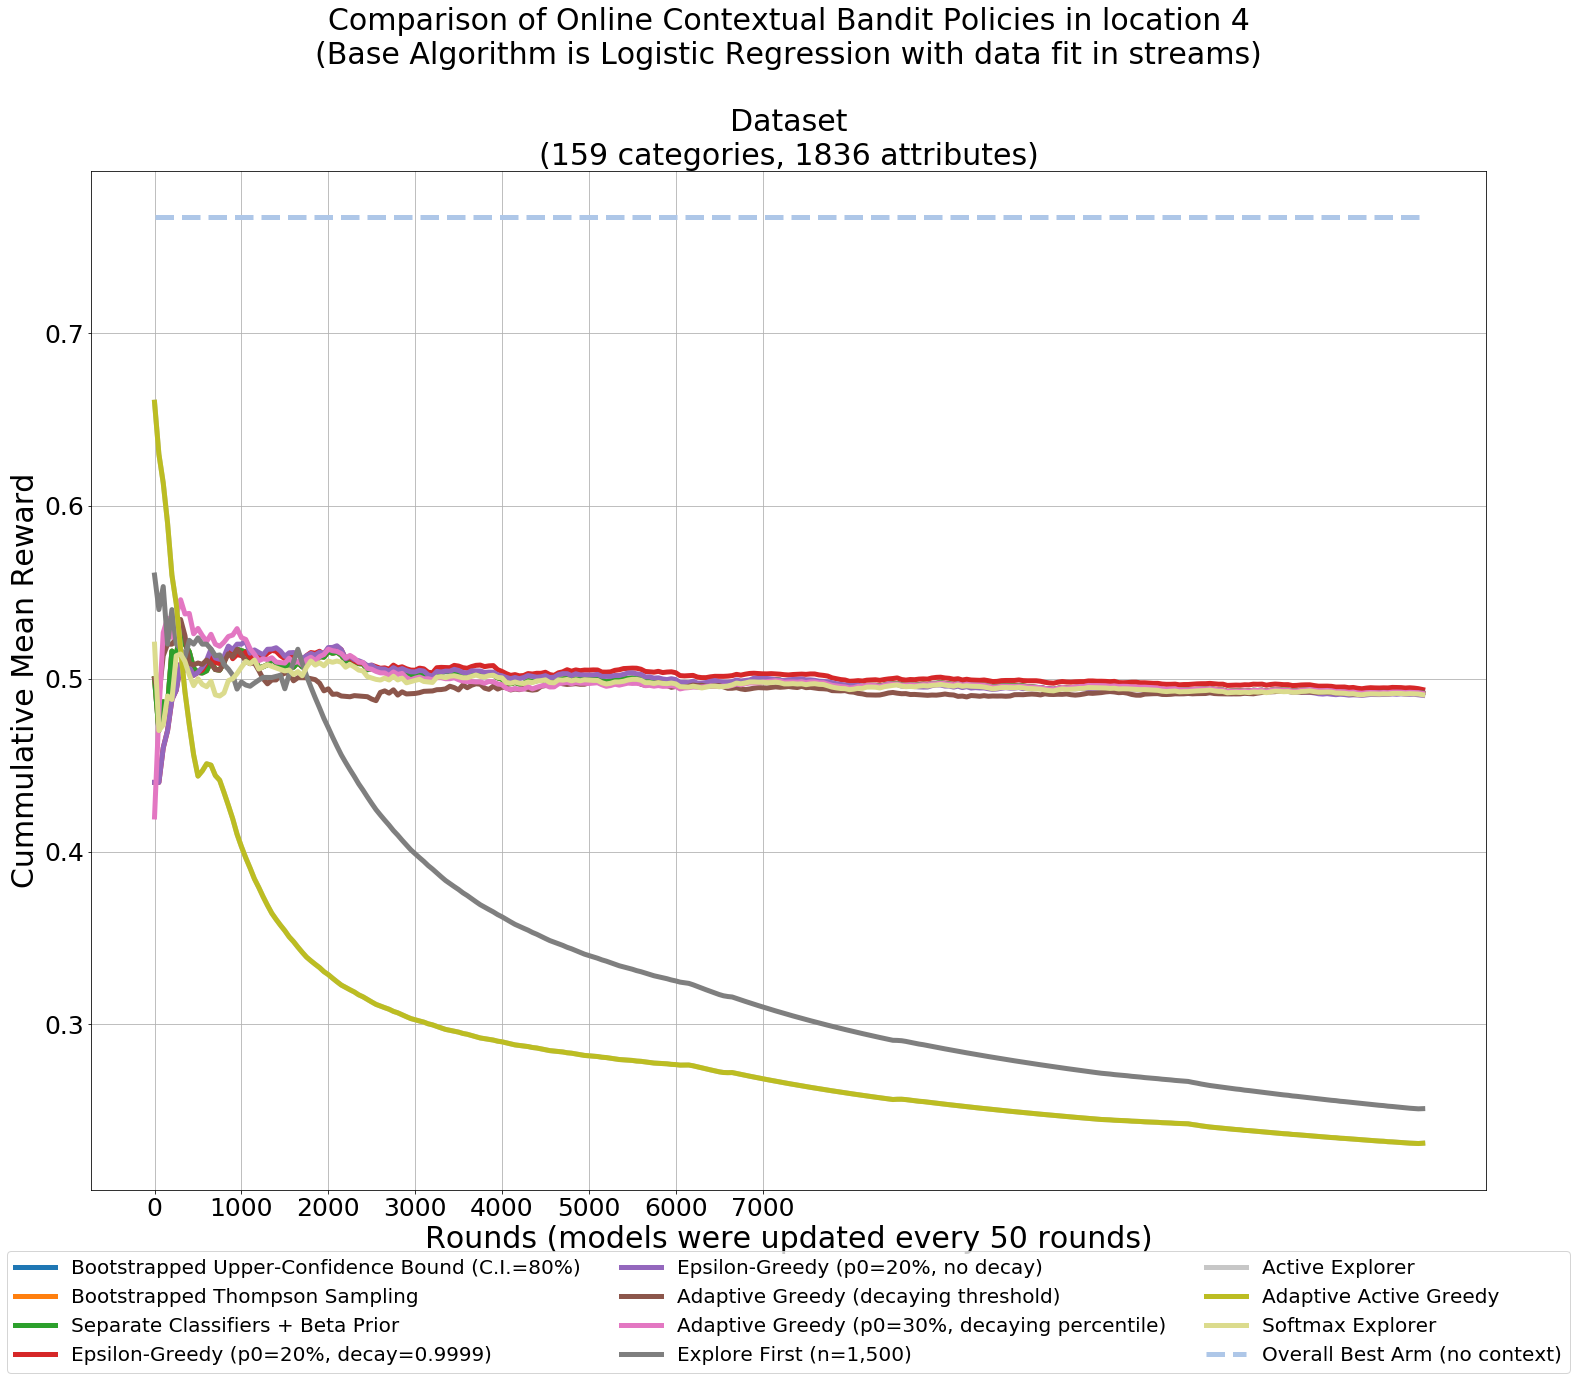

In [5]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_4.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies in location 4\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

/home/aziza/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


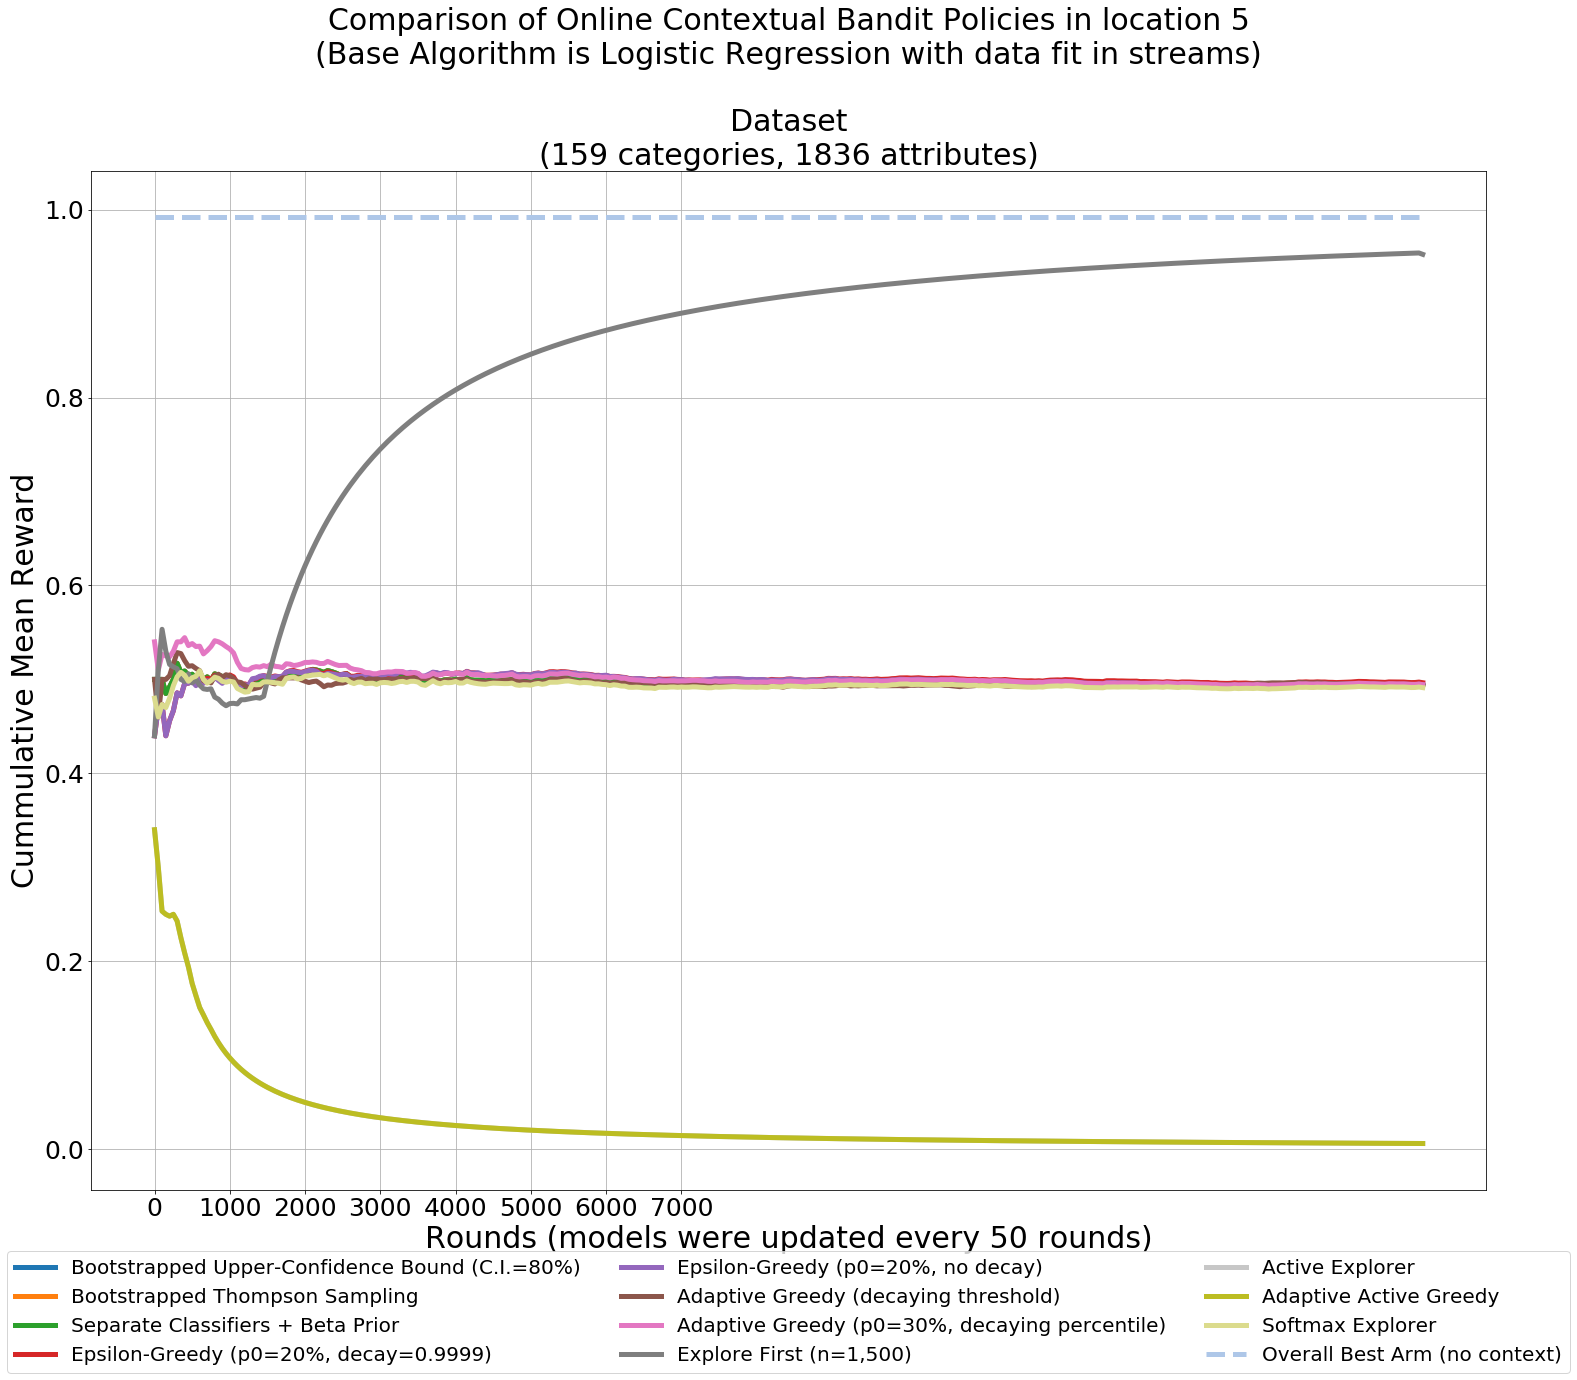

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_5.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies in location 5\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [5]:
array_rewards_ucb = np.array(rewards_ucb)
np.savetxt('array.csv', [array_rewards_ucb], delimiter=',', fmt='%d')

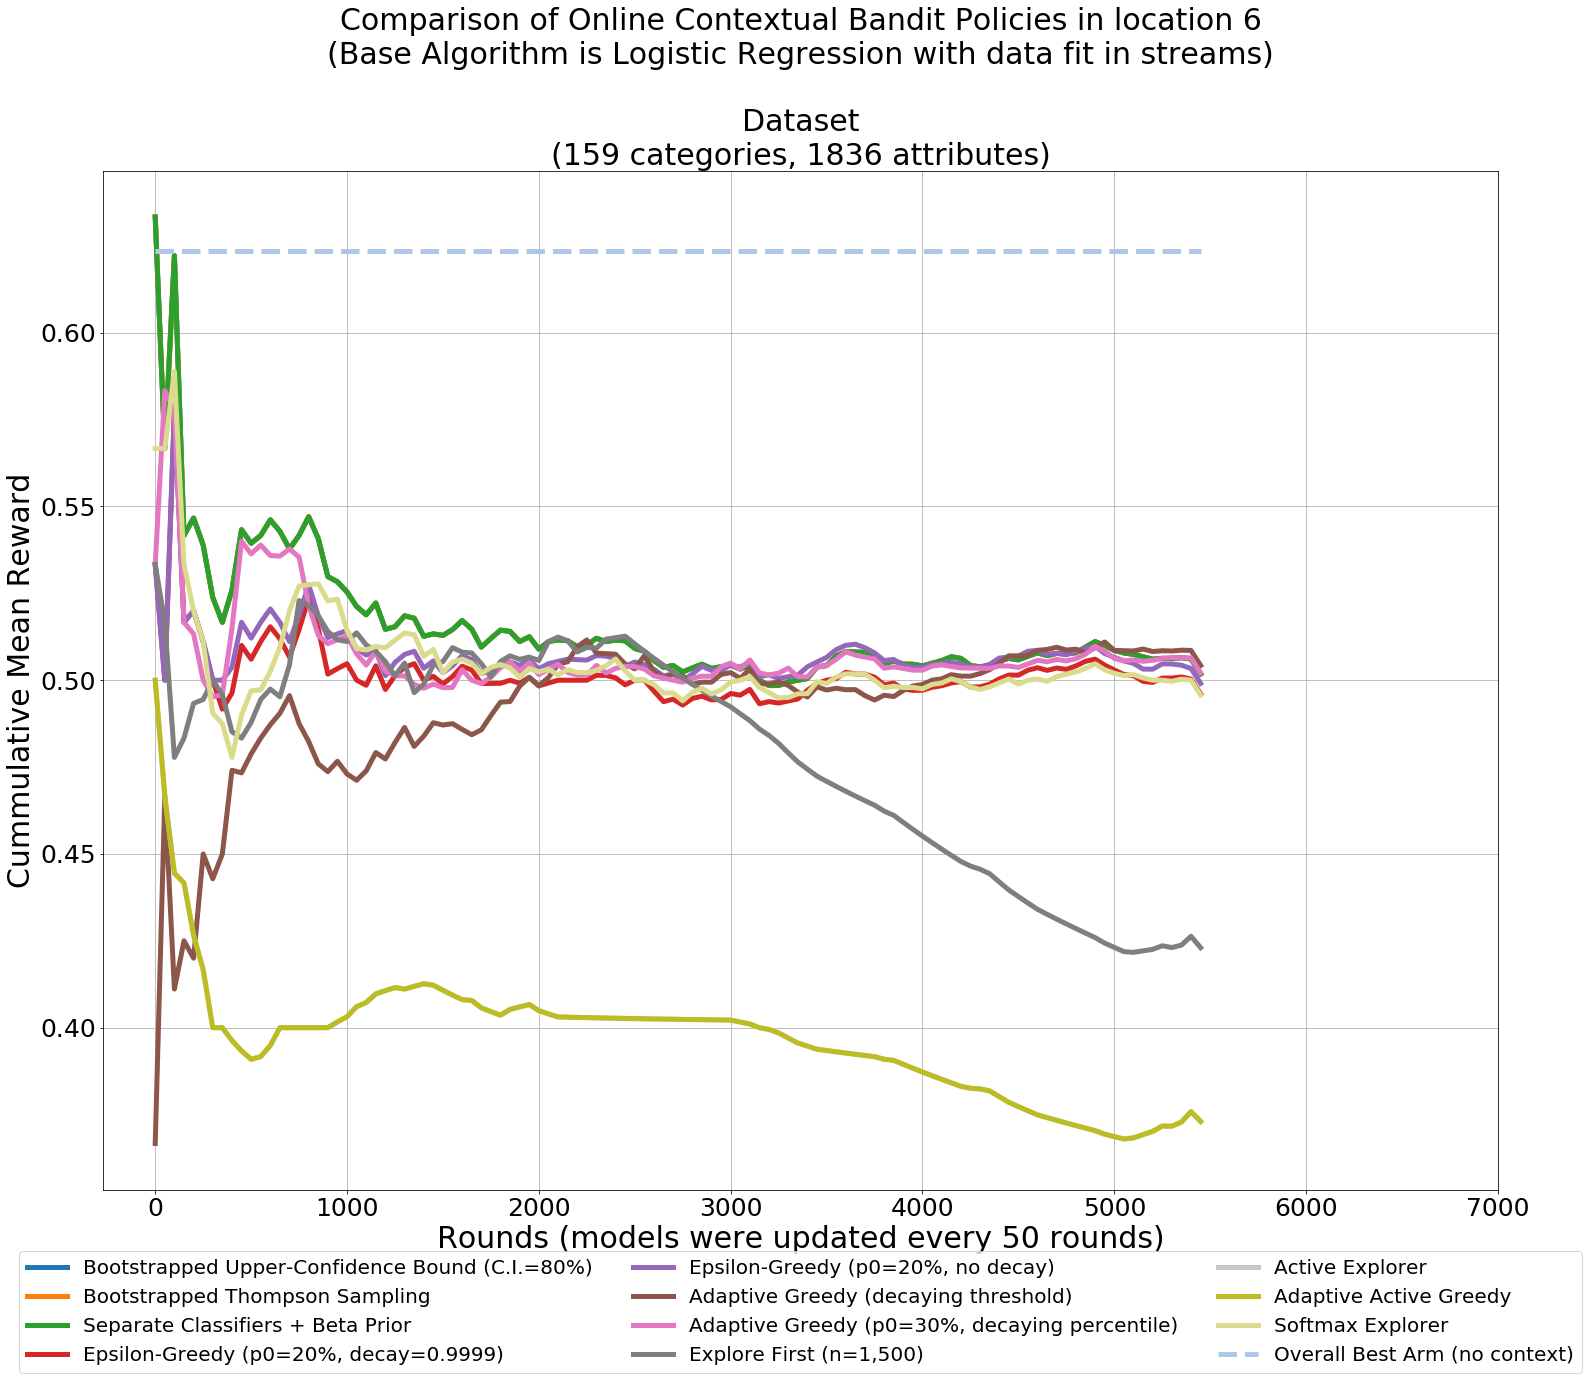

In [4]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_6.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=30

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies in location 6\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
#plt.grid()
f = plt.figure()
plt.show()
f.savefig("loc_6.png", bbox_inches='tight', dpi=600)

In [9]:
f = plt.figure()
plt.show()
f.savefig("loc_6.png")

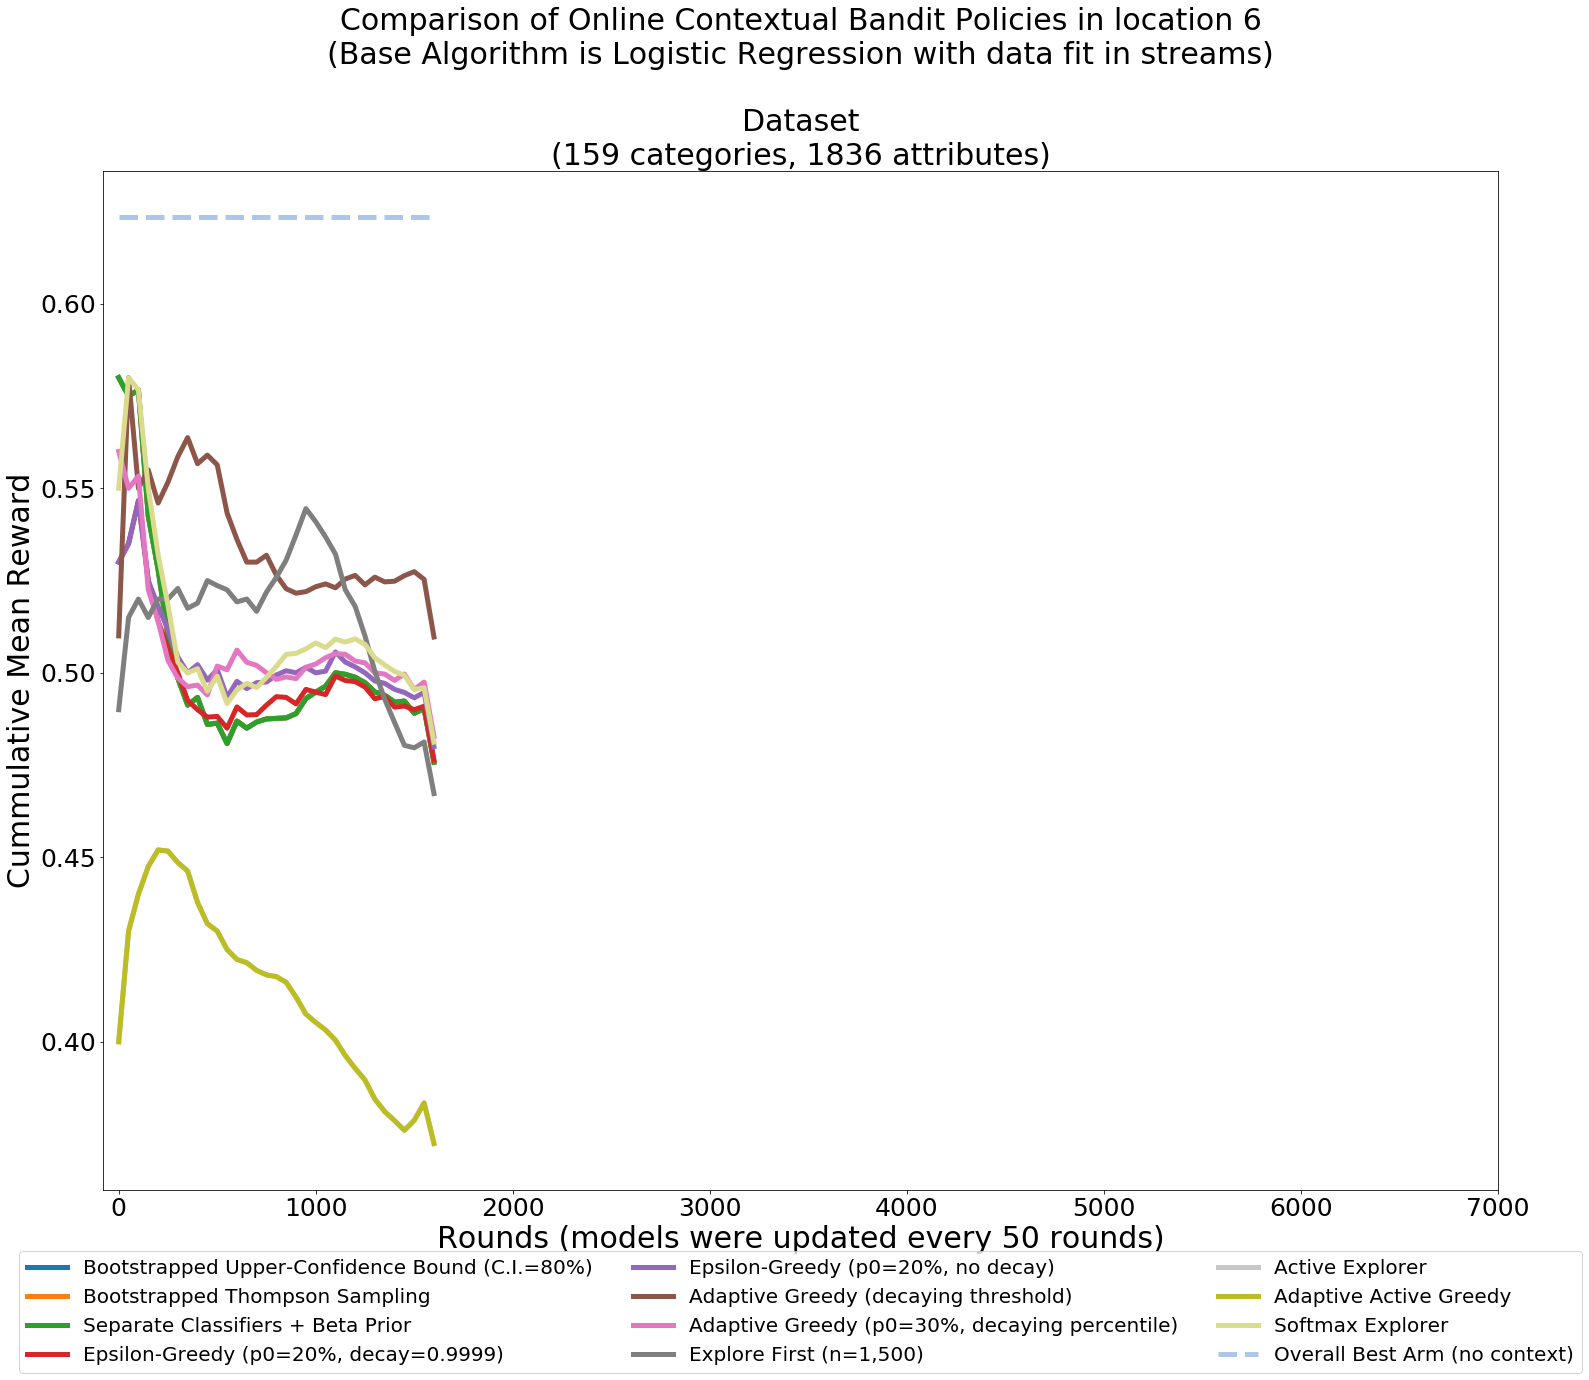

<Figure size 1800x1080 with 0 Axes>

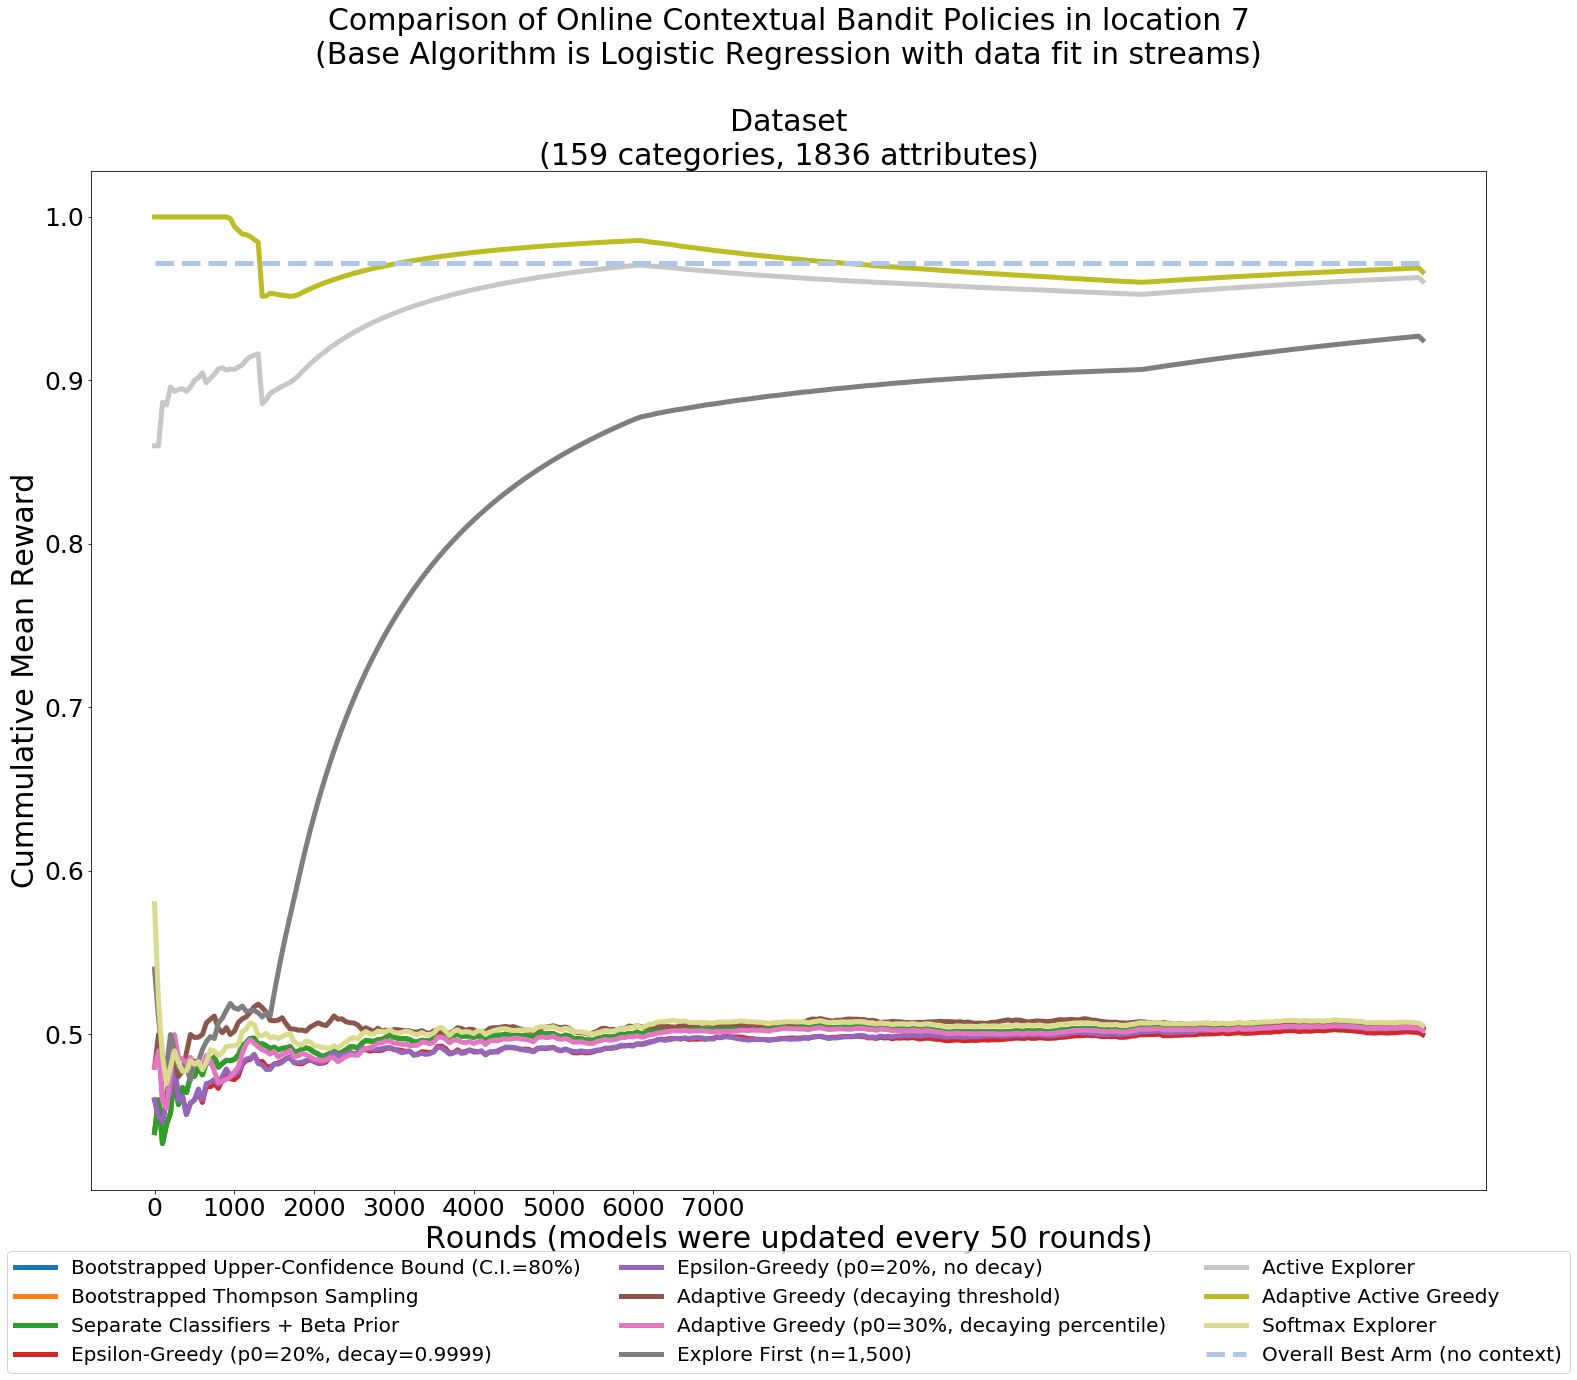

In [27]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from sklearn.linear_model import SGDClassifier

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("loc_7.txt")


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior, decay=None, batch_train=True)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold', batch_train=True)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             beta_prior=None, explore_rounds=1500, batch_train=True)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997, batch_train=True)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior, batch_train=True)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, epsilon_greedy_nodecay,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_egr2,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_egr2, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac,lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)
        
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper-Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_egr2), label="Epsilon-Greedy (p0=20%, no decay)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies in location 7\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
#plt.grid()
plt.savefig("loc_7.png", bbox_inches='tight')
plt.show()

from numpy import array
ucb, ts, ovr, egr, egr2, agr, agr2, efr, ac, aac, sft = array(rewards_ucb), array(rewards_ts), array(rewards_ovr), \
array(rewards_egr), array(rewards_egr2), array(rewards_agr), array(rewards_agr2), array(rewards_efr), \
array(rewards_ac), array(rewards_aac), array(rewards_sft)
df = pd.DataFrame({"ucb" : ucb, "ts" : ts,"ovr":ovr, "egr":egr,"egr2":egr2,"agr":agr,"agr2":agr2,"efr":efr, \
                  "ac":ac, "aac":aac, "sft":sft})
df.to_csv("rewards_loc7.csv", index=False)

In [11]:
rewards_ucb

[78,
 89,
 73,
 73,
 55,
 73,
 64,
 76,
 81,
 76,
 71,
 84,
 72,
 66,
 83,
 85,
 81,
 61,
 81,
 74,
 71,
 1]

In [26]:
from numpy import array
ucb, ts, ovr, egr, egr2, agr, agr2, efr, ac, aac, sft = array(rewards_ucb), array(rewards_ts), array(rewards_ovr), \
array(rewards_egr), array(rewards_egr2), array(rewards_agr), array(rewards_agr2), array(rewards_efr), \
array(rewards_ac), array(rewards_aac), array(rewards_sft)
df = pd.DataFrame({"ucb" : ucb, "ts" : ts,"ovr":ovr, "egr":egr,"egr2":egr2,"agr":agr,"agr2":agr2,"efr":efr, \
                  "ac":ac, "aac":aac, "sft":sft})
df.to_csv("rewards_loc7.csv", index=False)

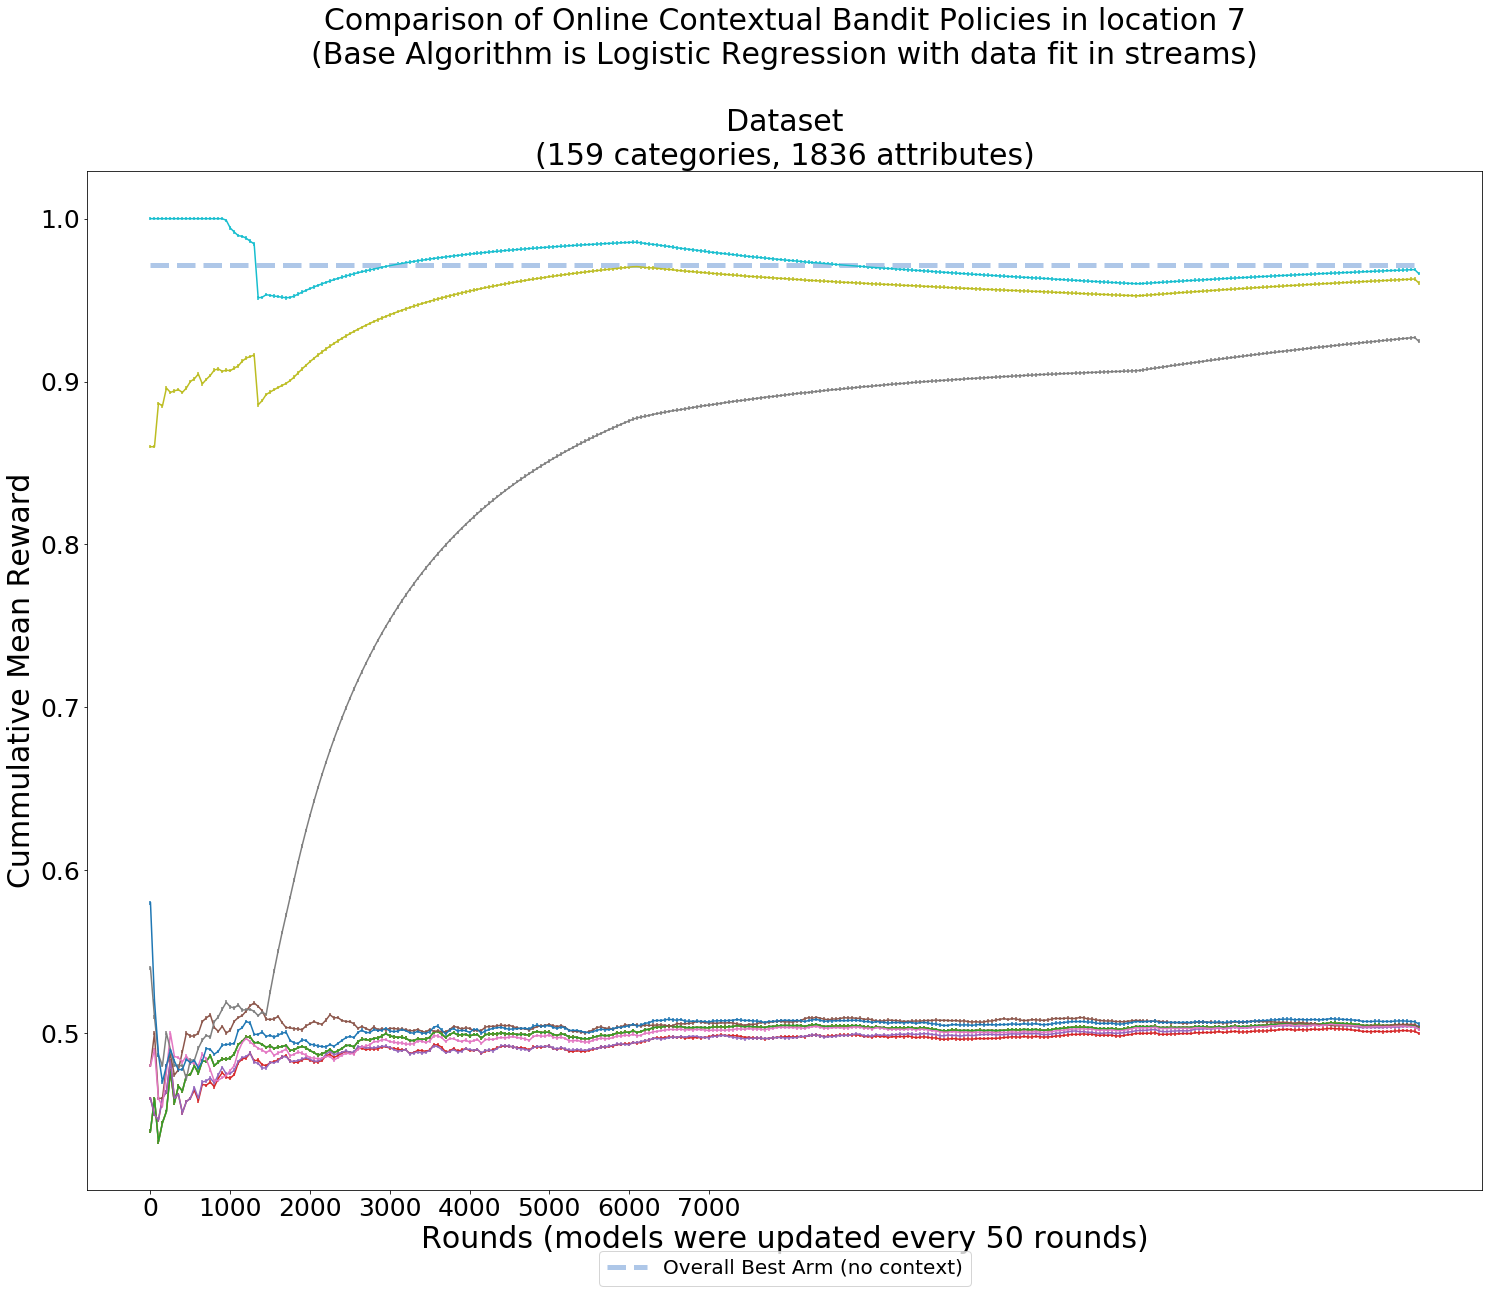

In [76]:
#plotting

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

import scipy.stats as st
y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11 = get_mean_reward(rewards_ucb), get_mean_reward(rewards_ts) \
,get_mean_reward(rewards_ovr), get_mean_reward(rewards_egr), get_mean_reward(rewards_egr2) \
,get_mean_reward(rewards_agr), get_mean_reward(rewards_agr2), get_mean_reward(rewards_efr) \
,get_mean_reward(rewards_ac), get_mean_reward(rewards_aac), get_mean_reward(rewards_sft)
x1, x2 = [index for index in range(len(rewards_ucb))], [index for index in range(len(rewards_ts))]
x3, x4 = [index for index in range(len(rewards_ovr))], [index for index in range(len(rewards_egr))]
x5, x6 = [index for index in range(len(rewards_egr2))], [index for index in range(len(rewards_agr))]
x7, x8 = [index for index in range(len(rewards_agr2))], [index for index in range(len(rewards_efr))]
x9, x10 = [index for index in range(len(rewards_ac))], [index for index in range(len(rewards_aac))]
x11 = [index for index in range(len(rewards_sft))]


def CI_model(y, confidence = 0.95):
    std_err_y = st.sem(y1)
    n_y = len(y1)
    h_y = std_err_y * st.t.ppf((1 + confidence) / 2, n_y - 1)
    return h_y

h_y1, h_y2, h_y3, h_y4, h_y5, h_y6, h_y7, h_y8, h_y9, h_y10, h_y11 = CI_model(y1), CI_model(y2), CI_model(y3),\
CI_model(y4), CI_model(y5), CI_model(y6), CI_model(y7), CI_model(y8), CI_model(y9), CI_model(y10), CI_model(y11)
plt.errorbar(x1, y1, yerr= h_y1)
plt.errorbar(x2, y2, yerr= h_y2)
plt.errorbar(x3, y3, yerr= h_y3)
plt.errorbar(x4, y4, yerr= h_y4)
plt.errorbar(x5, y5, yerr= h_y5)
plt.errorbar(x6, y6, yerr= h_y6)
plt.errorbar(x7, y7, yerr= h_y7)
plt.errorbar(x8, y8, yerr= h_y8)
plt.errorbar(x9, y9, yerr= h_y9)
plt.errorbar(x10, y10, yerr= h_y10)
plt.errorbar(x11, y11, yerr= h_y11)
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')



box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies in location 7\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nDataset\n(159 categories, 1836 attributes)',size=30)
#plt.grid()
#plt.savefig("loc_7.png", bbox_inches='tight')

plt.show()

# from numpy import array
# ucb, ts, ovr, egr, egr2, agr, agr2, efr, ac, aac, sft = array(rewards_ucb), array(rewards_ts), array(rewards_ovr), \
# array(rewards_egr), array(rewards_egr2), array(rewards_agr), array(rewards_agr2), array(rewards_efr), \
# array(rewards_ac), array(rewards_aac), array(rewards_sft)
# df = pd.DataFrame({"ucb" : ucb, "ts" : ts,"ovr":ovr, "egr":egr,"egr2":egr2,"agr":agr,"agr2":agr2,"efr":efr, \
#                   "ac":ac, "aac":aac, "sft":sft})
#df.to_csv("rewards_loc7.csv", index=False)



<ErrorbarContainer object of 3 artists>

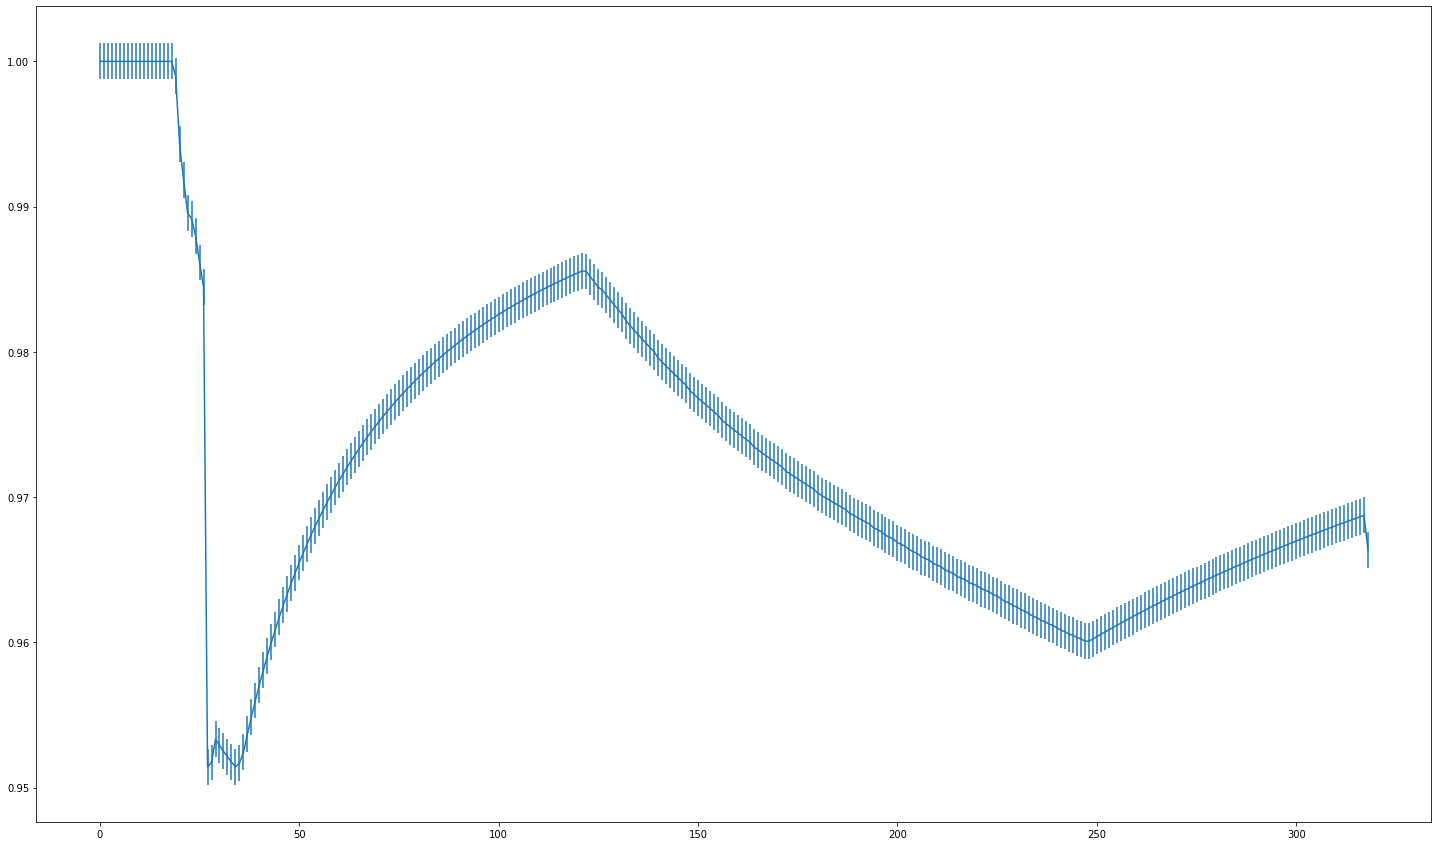

In [77]:
import scipy.stats as st
y1, y2 = get_mean_reward(rewards_ucb), get_mean_reward(rewards_aac)
x1 = [index for index in range(len(rewards_ucb))]

x2 = [index for index in range(len(rewards_aac))]

def CI_model(y1, confidence = 0.95):
    std_err_y = st.sem(y1)
    n_y = len(y1)
    h_y = std_err_y * st.t.ppf((1 + confidence) / 2, n_y - 1)
    return h_y

h_y1, h_y2 = CI_model(y1), CI_model(y2)
#plt.errorbar(x1, y1, yerr= h_y1)
plt.errorbar(x2, y2, yerr= h_y2)

In [67]:
h_y

0.0010697876453765645

In [44]:
len(y1)

319

In [46]:
y1.index()

TypeError: index() takes at least 1 argument (0 given)

In [38]:
y1

[0.44,
 0.46,
 0.43333333333333335,
 0.445,
 0.452,
 0.4766666666666667,
 0.45714285714285713,
 0.4675,
 0.46444444444444444,
 0.474,
 0.47454545454545455,
 0.48,
 0.4753846153846154,
 0.4828571428571429,
 0.4826666666666667,
 0.48625,
 0.48,
 0.4822222222222222,
 0.4842105263157895,
 0.484,
 0.4847619047619048,
 0.48727272727272725,
 0.4930434782608696,
 0.495,
 0.4976,
 0.4976923076923077,
 0.49407407407407405,
 0.4942857142857143,
 0.49310344827586206,
 0.49133333333333334,
 0.492258064516129,
 0.490625,
 0.4915151515151515,
 0.49176470588235294,
 0.49257142857142855,
 0.48944444444444446,
 0.4897297297297297,
 0.49105263157894735,
 0.4917948717948718,
 0.491,
 0.4892682926829268,
 0.4880952380952381,
 0.4865116279069767,
 0.48727272727272725,
 0.48844444444444446,
 0.49,
 0.48808510638297875,
 0.4891666666666667,
 0.4906122448979592,
 0.4924,
 0.49254901960784314,
 0.49153846153846154,
 0.49471698113207546,
 0.4962962962962963,
 0.496,
 0.4957142857142857,
 0.4968421052631579,
 0.4

In [49]:
np.arrange(y1[:])

AttributeError: module 'numpy' has no attribute 'arrange'

In [54]:
y1_arr = array(y1)
x1 = y1_arr.index[:]

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [58]:
list.index(rewards_ucb)

TypeError: index() takes at least 1 argument (0 given)

In [62]:
type(rewards_ucb)

list

In [63]:
indexes = [index for index in range(len(rewards_ucb))]

In [64]:
indexes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
